In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.layers import Dense, Dropout, LSTM,Conv1D, TimeDistributed, Flatten, SpatialDropout1D, GlobalAveragePooling1D, SimpleRNN, MaxPooling1D, GlobalMaxPooling1D, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, f1_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, precision_score, classification_report
from numpy import sqrt
from numpy import argmax
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
from numpy import genfromtxt

/Users/niall/opt/anaconda3/envs/DCUML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/niall/opt/anaconda3/envs/DCUML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/niall/opt/anaconda3/envs/DCUML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/niall/opt/anaconda3/envs/DCUML

In [2]:
def get_data():
    input_file = '/Users/niall/Documents/Cypress_Code/Data/Flip_bits/flip_bits_dataset_final.csv'
    my_data_flipped = genfromtxt(input_file, delimiter=',')

    new_data = np.delete(my_data_flipped, (0), axis=0)
    X2 = np.delete(new_data, (0,32), axis=1)
    Y2 = new_data[:,32]
    X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.25, random_state=42, shuffle=True)
    X_train = np.array(X_train).reshape((np.shape(X_train)[0], 1, np.shape(X_train)[1]))
    X_test = np.array(X_test).reshape((np.shape(X_test)[0], 1, np.shape(X_test)[1]))

    return X_train, X_test, y_train, y_test

In [3]:
flip_bit_data = get_data()
X_train = flip_bit_data[0]
X_test = flip_bit_data[1]
y_train = flip_bit_data[2]
y_test = flip_bit_data[3]

In [4]:
num_neurons = 31
num_features = 31

model_bidir = Sequential()
model_bidir.add(Bidirectional(LSTM(num_neurons, return_sequences=True),input_shape=(1, num_features)))
model_bidir.add(Bidirectional(LSTM(num_neurons, return_sequences=True),input_shape=(1, num_features)))
model_bidir.add(GlobalMaxPooling1D())
model_bidir.add(Dense(16, activation='sigmoid'))
model_bidir.add(Dropout(0.2))
model_bidir.add(Dense(1, activation='sigmoid'))


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_bidir.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bidir.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 62)             15624     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1, 62)             23312     
_________________________________________________________________
global_max_pooling1d (Global (None, 62)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1008      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)      

In [5]:
print('Training BLSTM...')

batch_size = 5

history_one_blstm = model_bidir.fit(X_train, y_train, 
                                      batch_size=batch_size,
                                      epochs=5,
                                      validation_data=(X_test, y_test), 
                                      callbacks=[rlrp] ,verbose=1)

Training BLSTM...
Train on 450000 samples, validate on 150000 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/5
450000/450000 [==============================] - 645s 1ms/sample - loss: 0.0418 - acc: 0.9860 - val_loss: 0.0379 - val_acc: 0.9865
Epoch 2/5
450000/450000 [==============================] - 550s 1ms/sample - loss: 0.0366 - acc: 0.9877 - val_loss: 0.0360 - val_acc: 0.9876
Epoch 3/5
450000/450000 [==============================] - 541s 1ms/sample - loss: 0.0355 - acc: 0.9879 - val_loss: 0.0344 - val_acc: 0.9878
Epoch 4/5
450000/450000 [==============================] - 531s 1ms/sample - loss: 0.0350 - acc: 0.9881 - val_loss: 0.0348 - val_acc: 0.9875
Epoch 5/5
450000/450000 [==============================] - 550s 1ms/sample - loss: 0.0348 - acc: 0.9880 - val_loss: 0.0362 - val_acc: 0.9876


In [6]:
# Let's save the model to disc
json = model_bidir.to_json()
with open("/Users/niall/Documents/Cypress_Code/Models/BLSTM/Flip_bits/model_one_blstm.json", "w") as file:
    file.write(json)
model_bidir.save_weights("/Users/niall/Documents/Cypress_Code/Models/BLSTM/Flip_bits/model_one_blstm.h5")
print("Saved model to disc")

Saved model to disc


In [4]:
# Load the model of interest
json_file = open('/Users/niall/Documents/Cypress_Code/Models/BLSTM/Flip_bits/model_one_blstm.json', 'r')
json = json_file.read()
json_file.close()
model_avg_from_disc = model_from_json(json)
model_avg_from_disc.load_weights("/Users/niall/Documents/Cypress_Code/Models/BLSTM/Flip_bits/model_one_blstm.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
y_preds_blstm_minus = model_avg_from_disc.predict(X_test, batch_size=1)

In [9]:
pred_avg = pd.DataFrame(y_preds_blstm_minus, columns =['Y_pred']) 
pred_avg['Label'] = y_test

In [10]:
pred_avg.to_csv('/Users/niall/Documents/Cypress_Code/Predictions/BLSTM/Flip_bits/model_one_blstm.csv', index = False)

In [6]:
yhat = model_avg_from_disc.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, yhat)
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.401411, G-Mean=0.987


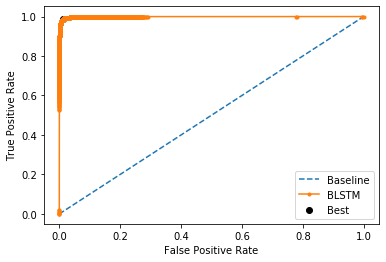

In [16]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Baseline')
plt.plot(fpr, tpr, marker='.', label='BLSTM')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.savefig('/Users/niall/Documents/Cypress_Code/Plots/Matlab_flip_bits/BLSTM_ROC.png')
plt.show()

In [7]:
auc = roc_auc_score(y_test, yhat)
print('ROC AUC=%.3f' % (auc))

ROC AUC=0.999


In [5]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
    
yhat_new = model_avg_from_disc.predict_classes(X_test)
metrics(yhat_new, y_test)

F1-score:  0.9814574559390032
Precision:  0.9830271286059855
Recall:  0.9798927881070525
Acuracy:  0.9876133333333333
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     99819
           1       0.98      0.98      0.98     50181

    accuracy                           0.99    150000
   macro avg       0.99      0.99      0.99    150000
weighted avg       0.99      0.99      0.99    150000

